In [3]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('ggplot')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 15)

In [5]:
df = pd.read_csv('../data/processed/cleaned_data.csv')
df.head()

/home/maureen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Datetime,X,Y,OBJECTID,INCKEY,ADDRTYPE,INTKEY,LOCATION,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,JUNCTIONTYPE,SDOT_COLCODE,UNDERINFL,ST_COLCODE,CROSSWALKKEY,SPEEDING_Y,INATTENTIONIND_Y,HITPARKEDCAR_Y,PEDROWNOTGRNT_Y,WEATHER_Adverse,WEATHER_Good,WEATHER_Unknown,ROADCOND_Adverse,ROADCOND_Dry,ROADCOND_Unknown,LIGHTCOND_Dark,LIGHTCOND_Daylight,LIGHTCOND_Unknown,LIGHTCOND_VeryDark,SEVERITYCODE_Injury,SEVERITYCODE_PropertyDamage,SEVERITYCODE_Unknown
0,2004-01-01 00:00:00,NaN,NaN,11627,25040,Block,NaN,BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB ...,2,0,0,2,1,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),14.0,0,13,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
1,2004-01-01 00:00:00,-122.318760,47.604359,12525,24635,Block,NaN,E ALDER ST BETWEEN 10TH AVE AND 11TH AVE,2,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),16.0,0,32,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
2,2004-01-01 00:00:00,-122.320780,47.614076,14172,26463,Intersection,29745.0,BROADWAY AND E PIKE ST,4,0,0,2,1,0,0,2004/01/01 00:00:00+00,At Intersection (intersection related),11.0,0,28,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0
3,2004-01-01 00:00:00,-122.383351,47.529183,6538,19530,Block,NaN,SW ROSE ST BETWEEN 39TH AVE SW AND 41ST AVE SW,2,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),14.0,0,32,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0
4,2004-01-01 00:00:00,-122.329974,47.708637,9665,22520,Block,NaN,N NORTHGATE WAY BETWEEN CORLISS AVE N AND 1ST ...,1,0,0,1,0,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),28.0,0,50,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


In [7]:
# Drop columns and check NaN
to_drop = ['Datetime', 'X', 'Y', 'OBJECTID', 'INCKEY', 'ADDRTYPE', 'LOCATION', 
           'INCDATE', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'ST_COLCODE', 'INTKEY',
           'PERSONCOUNT']
data = df.drop(columns=to_drop)
data.isnull().sum()

PEDCOUNT                       0
PEDCYLCOUNT                    0
VEHCOUNT                       0
INJURIES                       0
SERIOUSINJURIES                0
                              ..
LIGHTCOND_Unknown              0
LIGHTCOND_VeryDark             0
SEVERITYCODE_Injury            0
SEVERITYCODE_PropertyDamage    0
SEVERITYCODE_Unknown           0
Length: 25, dtype: int64

## Start the base model
1. Define target based on our business case
a. Binary injury/not injury, collisions with pedestrains/cyclists vs not, etc
2. Create train/test split
3. Train model
4. Evaluate metrics

In [9]:
# Define our target. In this case can use severitycode_injury
data['SEVERITYCODE_Injury'].value_counts()
#data['INJURIES_OCCURED'] = (data['SEVERITYCODE'] == 2).astype(int)

0    133398
1     60906
Name: SEVERITYCODE_Injury, dtype: int64

In [10]:
y = data.pop('SEVERITYCODE_Injury')
X = data.drop(columns=['SEVERITYCODE_Unknown', 'SEVERITYCODE_PropertyDamage', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'])
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [11]:
# Create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify configuration
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
}

gbm = lgb.train(params, 
                lgb_train, 
                num_boost_round=20, 
                valid_sets=lgb_eval, 
                early_stopping_rounds=5)

gbm.save_model('lgbm_model.txt')

[1]	valid_0's binary_logloss: 0.615354
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.609598
[3]	valid_0's binary_logloss: 0.603293
[4]	valid_0's binary_logloss: 0.597303
[5]	valid_0's binary_logloss: 0.592736
[6]	valid_0's binary_logloss: 0.589813
[7]	valid_0's binary_logloss: 0.58631
[8]	valid_0's binary_logloss: 0.582589
[9]	valid_0's binary_logloss: 0.578604
[10]	valid_0's binary_logloss: 0.576042
[11]	valid_0's binary_logloss: 0.572641
[12]	valid_0's binary_logloss: 0.569532
[13]	valid_0's binary_logloss: 0.567275
[14]	valid_0's binary_logloss: 0.565345
[15]	valid_0's binary_logloss: 0.563378
[16]	valid_0's binary_logloss: 0.561394
[17]	valid_0's binary_logloss: 0.559386
[18]	valid_0's binary_logloss: 0.557465
[19]	valid_0's binary_logloss: 0.555823
[20]	valid_0's binary_logloss: 0.554237
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.554237


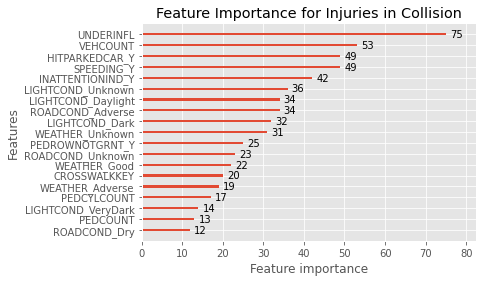

In [12]:
# Get feature importances for injury occuring in collision
lgb.plot_importance(gbm, title="Feature Importance for Injuries in Collision")

In [21]:
# Do prediction and get AUC score
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
auc_score = roc_auc_score(y_test, y_pred)

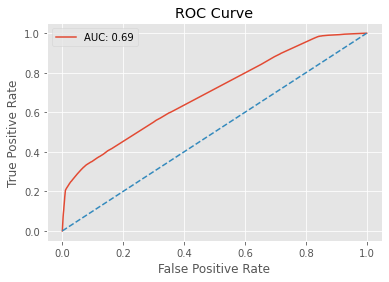

In [27]:
# Plot AUC 
# THIS LOOKS OFF -> INVESTIGATE
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label='AUC: {:2.2f}'.format(auc_score))
ax.legend('lower right')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')

In [19]:
thresholds

array([1.72726992, 0.72726992, 0.71535543, 0.71372284, 0.70840779,
       0.70697146, 0.70135848, 0.69978355, 0.69920772, 0.69918863,
       0.6989753 , 0.69886246, 0.69867139, 0.6984064 , 0.6982836 ,
       0.69614989, 0.69564113, 0.69534398, 0.69460597, 0.69457169,
       0.69420844, 0.69400338, 0.69390193, 0.69257881, 0.69250615,
       0.69204195, 0.69187161, 0.69122362, 0.69117123, 0.69081403,
       0.69048965, 0.69047126, 0.69039103, 0.69027719, 0.68993237,
       0.68958671, 0.68885372, 0.68877649, 0.68828019, 0.68738537,
       0.68696586, 0.68674144, 0.68600868, 0.68578739, 0.6855467 ,
       0.68542482, 0.68499228, 0.68418787, 0.68387009, 0.68347285,
       0.68136486, 0.68029541, 0.67539799, 0.67523698, 0.67179654,
       0.66606201, 0.66327385, 0.65828484, 0.65213664, 0.64581537,
       0.64371649, 0.63560989, 0.63406213, 0.63390523, 0.62985735,
       0.62939114, 0.62933713, 0.62851302, 0.62736378, 0.62728545,
       0.62658129, 0.6258957 , 0.62522243, 0.62508992, 0.62450